# Imports

In [1]:
import copy
import functools
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import numpy as np
from IPython.core.display import display, HTML

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models

import time

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=150)
np.set_printoptions(edgeitems=10)

# Load Data

In [3]:
batch_size=64
image_shape = [32,32]
color_channels = 3
powers = [(2**x)*color_channels for x in range(3,20)]
print("Channel Progression:",powers)
data_shape = [batch_size,color_channels]+image_shape
print(data_shape)

train_data= datasets.CIFAR10('data10', 
                      train=True, 
                      download=True,
                      transform=transforms.Compose([
                          transforms.Resize(image_shape),
                          transforms.ToTensor(),
                          transforms.Normalize((0,), (1,))]
                      ))
test_data= datasets.CIFAR10('data10', 
                      train=False,
                      download=False,
                      transform=transforms.Compose([
                          transforms.Resize(image_shape),
                          transforms.ToTensor(),
                          transforms.Normalize((0,), (1,))]
                      ))
                      
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)

batches = len(train_loader)
print("Factors of",batches,"batches: ",[x for x in range(1,batches) if (batches/x)%1==0])

Channel Progression: [24, 48, 96, 192, 384, 768, 1536, 3072, 6144, 12288, 24576, 49152, 98304, 196608, 393216, 786432, 1572864]
[64, 3, 32, 32]
Files already downloaded and verified
Factors of 782 batches:  [1, 2, 17, 23, 34, 46, 391]


# Helpers

In [4]:
def padsize(s,k=3,d=1):
    pad = math.ceil((k*d-d+1-s)/2)
    return pad

def general_num_params(model):
    return sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())])
    
def eq_string(n):
    return "="*n

# Operations

In [5]:
class Dilated_Conv(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding, dilation, affine=True):
        super(Dilated_Conv, self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=C_in, bias=False),
            nn.Conv2d(C_in, C_out, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_out, affine=affine),
        )  
    def forward(self, x):
        return self.op(x)

class Single_Conv(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
        super(Single_Conv, self).__init__()
        self.op = nn.Sequential(
          nn.ReLU(inplace=False),
          nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, padding=padding, groups=C_in, bias=False),
          nn.BatchNorm2d(C_out, affine=affine),
          )
    def forward(self, x):
        return self.op(x)

class xBy1_Conv(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
        super(xBy1_Conv,self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(C_in, C_in, kernel_size=(1,kernel_size), stride=stride, padding=(0,padding), bias=False),
            nn.Conv2d(C_in, C_in, kernel_size=(kernel_size,1), padding=(padding,0), bias=False),
            nn.BatchNorm2d(C_in,affine=affine),
        )
    def forward(self,x):
        return self.op(x)

class Separable_Conv(nn.Module):  
    def __init__(self, C_in, C_out, kernel_size, stride, padding, affine=True):
        super(Separable_Conv, self).__init__()
        self.op = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=stride, padding=padding, groups=C_in, bias=False),
            nn.Conv2d(C_in, C_in, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_in, affine=affine),
            nn.ReLU(inplace=False),
            nn.Conv2d(C_in, C_in, kernel_size=kernel_size, stride=1, padding=padding, groups=C_in, bias=False),
            nn.Conv2d(C_in, C_in, kernel_size=1, padding=0, bias=False),
            nn.BatchNorm2d(C_out, affine=affine),
        )
        
    def forward(self, x):
        return self.op(x)

class Identity(nn.Module):
    def __init__(self,C_in,C_out,stride):
        super(Identity, self).__init__()
        if C_in==C_out:
            self.identity = nn.MaxPool2d(1,stride=stride)
        else:
            self.identity = nn.Conv2d(C_in, C_out, kernel_size=1,stride=stride)
    def forward(self, x):
        return self.identity(x)
        
class Zero(nn.Module):
    def __init__(self):
        super(Zero, self).__init__()
    def forward(self, x):
        return x.mul(0.)
    
class nn_View(nn.Module):
    def __init__(self):
        super(nn_View, self).__init__()
    def forward(self, x):
        return x.view(x.size()[0], -1)
    
class Classifier(nn.Module):
    def __init__(self,in_size,out_size):
        super(Classifier,self).__init__()
        self.in_size = in_size
        self.out_size= out_size
        
        self.op = nn.Sequential(
            nn_View(),
            nn.Dropout(),
            nn.Linear(in_size, in_size),
            nn.ReLU(inplace=True),
            nn.Linear(in_size, out_size),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        return self.op(x)
    
    def get_param_counts(self):
        return [general_num_params(op) for op in self.op]
    
    def __repr__(self):
        params = self.get_param_counts()
        out = "{} CLASSIFIER {}\n".format(eq_string(48),eq_string(48))
        out+= "nn_View:    {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.in_size,  params[0])
        out+= "Dropout:    {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.in_size,  params[1])
        out+= "Linear:     {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.in_size,  params[2])
        out+= "ReLU:       {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.in_size,  params[3])
        out+= "Linear:     {:<6} -> {:<6} ({:,} params)\n".format(self.in_size,self.out_size, params[4])
        out+= "Softmax:    {:<6} -> {:<6} ({:,} params)\n".format(self.out_size,self.out_size,params[5])
        return out

# Op Dict

In [6]:
commons = {
    'zero'               : Zero(),
    'identity'           : lambda C_in,stride          : Identity(C_in,C_in,           stride=stride),
    'avg_pool_3x3'       : lambda C_in,stride          : nn.AvgPool2d(3,               stride=stride, padding=padsize(s=stride), count_include_pad=False),
    'max_pool_3x3'       : lambda C_in,stride          : nn.MaxPool2d(3,               stride=stride, padding=padsize(s=stride)),
    'max_pool_5x5'       : lambda C_in,stride          : nn.MaxPool2d(5,               stride=stride, padding=padsize(s=stride,k=5)),
    'max_pool_7x7'       : lambda C_in,stride          : nn.MaxPool2d(7,               stride=stride, padding=padsize(s=stride,k=7)),
    '1x7_7x1_conv'       : lambda C_in,stride          : xBy1_Conv(C_in,C_in,7,        stride=stride, padding=padsize(s=stride,k=7)),
    '1x3_3x1_conv'       : lambda C_in,stride          : xBy1_Conv(C_in,C_in,3,        stride=stride, padding=padsize(s=stride)),
    'dil_conv_3x3'       : lambda C_in,stride          : Dilated_Conv(C_in, C_in, 3,   stride=stride, padding=padsize(s=stride,d=2), dilation=2),
    'conv_1x1'           : lambda C_in,stride          : Single_Conv(C_in, C_in, 1,    stride=stride, padding=padsize(s=stride,k=1)),
    'conv_3x3'           : lambda C_in,stride          : Single_Conv(C_in, C_in, 3,    stride=stride, padding=padsize(s=stride)),
    'sep_conv_3x3'       : lambda C_in,stride          : Separable_Conv(C_in, C_in, 3, stride=stride, padding=padsize(s=stride)),
    'sep_conv_5x5'       : lambda C_in,stride          : Separable_Conv(C_in, C_in, 5, stride=stride, padding=padsize(s=stride,k=5)),
    'sep_conv_7x7'       : lambda C_in,stride          : Separable_Conv(C_in, C_in, 7, stride=stride, padding=padsize(s=stride,k=7)),
}

padder = lambda C_in,C_out: Identity(C_in,C_out,stride=1)
op_list=list(commons.keys())
print(list(enumerate(op_list)))

[(0, 'zero'), (1, 'identity'), (2, 'avg_pool_3x3'), (3, 'max_pool_3x3'), (4, 'max_pool_5x5'), (5, 'max_pool_7x7'), (6, '1x7_7x1_conv'), (7, '1x3_3x1_conv'), (8, 'dil_conv_3x3'), (9, 'conv_1x1'), (10, 'conv_3x3'), (11, 'sep_conv_3x3'), (12, 'sep_conv_5x5'), (13, 'sep_conv_7x7')]


# Graph Edge Class

In [7]:
class Edge(nn.Module):
    def __init__(self,target,op):
        super(Edge, self).__init__()
    
        #edge attributes
        self.target      = target
        self.op          = op
        
        #forward functionality
        self.op_function = None
        self.padder      = lambda x: x
        
        #bookkeeping
        self.in_dim      = None
        self.out_dim     = None
        self.out         = None
    
    def forward(self,x):  
        return self.op_function(self.padder(x))
    
    def get_num_params(self):
        return general_num_params(self)
    
    def __str__(self):
        return self.__repr__()
    
    def __repr__(self):
        return "{:<18} -> {:<30} -> {:<18} to Node {} ({:,} params)".format(str(self.in_dim),self.op,str(self.out_dim),self.target.name,self.get_num_params())

# Graph Node Class

In [8]:
class Node(nn.Module):
    def __init__(self,name,dim=None):
        super(Node, self).__init__()
        
        #node attributes
        self.name=name
        self.dim = dim
        
        #node connections
        self.cnx = []
        self.ins  = []
        self.out = None
        
    def add_cnx(self,cnx,o_pos,t_pos):        
        #===DIMENSION MODIFICATION======================================
        in_channels=self.dim[1]
        
        #double channels if node receives cell input
        if o_pos==0:
            tgt_channels=[x for x in powers if x>in_channels][0]
            cnx.padder = padder(in_channels,tgt_channels)
            in_channels = tgt_channels
        else:
            tgt_channels = in_channels
        
        #halve spatial dimensions if node sends to output
        stride = 2 if t_pos==1 else 1
         
        #===CONNECTION SETTING==========================================
        #set attributes for connection
        cnx.op_function = commons[cnx.op](in_channels,stride=stride)
        cnx.in_dim = self.dim
        cnx.out_dim = [self.dim[0],
                         tgt_channels,
                         int(self.dim[2]/stride),
                         int(self.dim[3]/stride)]
        cnx.op+=" (by {}, {}->{})".format(stride,in_channels,tgt_channels)
        
        #===SANITY CHECKING=============================================
        #make sure tensors are of right dimensionality
        if cnx.target.dim == None or cnx.target.dim == cnx.out_dim:
            cnx.target.dim = cnx.out_dim
        else:
            raise ValueError("Dimension mismatch: Target Dim {} vs Edge Dim {}".format(cnx.target.dim,cnx.out_dim))
        
        self.cnx.append(cnx)
        
    def forward(self,x=None,verbose=False):
        #if cell connects to first node, pass in input
        if self.ins == []:
            self.ins = [x]
        
        if verbose:
            print("=== Node ",self.name,"===")
            print("Node Inputs:",[x.shape for x in self.ins])
        
        #add all input tensors together
        self.out = sum(self.ins)
        
        #clear memory of inputs (to avoid "retain-graph=True error")
        self.ins=[]
        
        #pass data through subsequent connections and set node output
        for cnx in self.cnx:
            if verbose:
                print("{}->{} via {}: {}->".format(self.name,cnx.target.name,cnx.op,self.out.shape),end="")
            cnx.out = cnx(self.out)
            cnx.target.ins.append(cnx.out)
            if verbose:
                print("{}".format(cnx.out.shape))
        return self.out
        
    def __repr__(self):
        out = ""
        out+="{} Node {} {}\n".format(eq_string(4),self.name,eq_string(4))
        if len(self.cnx) == 0:
            out+="{:<18} -> out\n".format(str(self.dim))
        else:
            for cnx in self.cnx:
                out+=str(cnx)+"\n"
        return out


# Cell Class

In [9]:
class Cell(nn.Module):
    def __init__(self,in_dim,matrix,reduce=False,verbose=False,to_probe=None):
        super(Cell, self).__init__()
        self.in_dim = in_dim
        self.nodes = nn.ModuleList()
        
        #create nodes
        for node in range(matrix.shape[0]):
            if node==0:
                self.nodes += [Node(0,in_dim)]
            else:
                self.nodes += [Node(node)]
        
        #create edge parameters
        self.edges = nn.ModuleList()
        matrix_width = matrix.shape[1]
        edgeQueue = list(zip(*matrix.nonzero()))
        
        #create edges and connect them to origin and target nodes
        for origin,target in edgeQueue:
            op = op_list[int(matrix[origin,target])]            
            if verbose:
                print(origin,target,op)
            new_edge = Edge(target=self.nodes[target],op=op)
            self.nodes[origin].add_cnx(new_edge,o_pos=origin/(matrix_width-1),t_pos=target/(matrix_width-1))
            self.edges.append(new_edge)
            
    def get_out_dim(self):
        #find output dimension of cell
        return self.nodes[-1].dim
    
    def get_upscale(self):
        #determine scaling ratios of cell
        filters =  self.nodes[-1].dim[1]/self.in_dim[1]
        dims = self.nodes[-1].dim[2]/self.in_dim[2]
        return filters,dims
    
    def forward(self,x,verbose):
        for i,node in enumerate(self.nodes):
            if i==0:
                #if node is the input node in cell, pass in cell input
                out=node.forward(x,verbose=verbose)
            else:
                #otherwise, nodes will receive input tensors from prior nodes
                out=node.forward(verbose=verbose)
        return out

    def __repr__(self):
        out = ""
        for i,node in enumerate(self.nodes):
            out+=str(node)
        return out

# Network Class

In [10]:
class Net(nn.Module):
    def __init__(self,cells,matrix,in_dim,classes):
        super(Net, self).__init__()
        self.cells = nn.ModuleList()
           
        #create and join cells
        for cell in range(cells):
            old_dim = in_dim
            new_cell = Cell(in_dim,matrix)
            in_dim = new_cell.get_out_dim()
            
            #make sure cells scale tensors correctly
            if cells>1 and old_dim[1]>=in_dim[1] and old_dim[2]<=in_dim[2]:
                raise ValueError("Cell doesn't properly scale")
                
            self.cells.append(new_cell)
        
        #append linear classifier after all cells
        self.classifier = Classifier(int(np.prod(in_dim[1:])),classes)
        
    #find scaling ratio of component cell
    def get_cell_upscale(self):
        return [cell.get_upscale() for cell in self.cells]
                
    def get_num_params(self):
        return general_num_params(self)
            
    def forward(self,x,verbose):
        #pass data through cells
        for cell in self.cells:
            x = cell(x,verbose)
        #pass data through classifier
        return self.classifier(x)

    def __repr__(self):
        out = ""
        for i,cell in enumerate(self.cells):
            out+="{} CELL {} {}\n".format(eq_string(50),i,eq_string(50))
            out+=str(cell)
            
        out+=str(self.classifier)
        out+="{}\nTOTAL PARAMS: {:,}\n".format(eq_string(108),self.get_num_params())
        return out  

# Graph Generator/Utilities

In [11]:
def gen_cell(nodes,sparsity_thresh):
    #generate random cell matrix with $nodes nodes
    #connects node_i to node_j with probabilty $sparsity thresh
    
    nn = np.zeros((nodes,nodes))
    for i in range(nodes):
        for j in range(nodes):
            if j>i:
                num = np.random.randint(1,13) if np.random.rand() > sparsity_thresh else 0
                nn[i,j]=num
            if j>0 and i==nodes-1 and all(nn[:,j]==0):
                nn[0,j]=1
        if i<nodes-1 and all(nn[i,]==0):
            nn[i,-1]=1
    return nn

def build_matrix(pairs):
    #build cell matrix from connectivity pairs
    #input [(0,1,3),(1,2,4)] means node0->node1 via op 3, node1->node2 via op4, etc
    
    nodes = max(np.max(pairs,0)[0:2])+1
    matrix = np.zeros([nodes,nodes])
    for origin,target,function in pairs:
        matrix[origin,target]=function
    return matrix
     
def show_matrix(matrix,name):
    #plot cell DAG
    g = nx.DiGraph()
    for origin,target in zip(*matrix.nonzero()):
        g.add_edge(origin,target,function=op_list[int(matrix[origin,target])])
    pos = nx.spring_layout(g)
    
    plt.figure(3,figsize=(12,12))
    nx.draw_networkx(g,pos)
    edge_labels = nx.get_edge_attributes(g,'function')
    nx.draw_networkx_edge_labels(g,pos=pos,edge_labels=edge_labels)
    plt.title(name)
    plt.show()
    
def cubify(matrix):
    #one hot each element in cell matrix (returns matrix of shape [n_nodes,n_nodes,n_ops])
    out = []
    ops = len(op_list)-1
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if j>i:
                row = np.zeros(ops)
                op = int(matrix[i,j])
                if op!=0:
                    row[op-1]=1
                out+= list(row)
    return np.array(out)

# Train/Test Loops

In [12]:
#single epoch train function
def train(model, device, train_loader, criterion, optimizer, epoch, validate=False,verbose=False):
    if not validate:
        print()
    ims = []
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)        
        
        optimizer.zero_grad()
        output = model.forward(data,verbose)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 2 == 0:
            if not validate:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()),
                     end="\n",flush=True)
        if validate:
            return True

#single epoch validation function
def test(model, device, test_loader):
    model.eval()
    test_loss= 0
    corrects = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output=model.forward(data,verbose=False)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            corrects += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss = np.round(test_loss/len(test_loader.dataset),2)
                
    print('\nTest Loss',test_loss,'Corrects',corrects,"/",len(test_loader.dataset))
    return test_loss
    
#run n epochs of the training and validation
def full_model_test(model,epochs):
    device = torch.device("cpu")
    lr=.05
    momentum=.9
    losses= []
    optimizer = optim.SGD(model.parameters(),lr=.025,momentum=.9,weight_decay=3e-4)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        train(model,device, train_loader, criterion, optimizer, epoch)
        losses.append(test(model,device,test_loader))
    return -min(losses)

def model_validate(model,verbose):
    if verbose:
        print("Validating model...",end="")
    device = torch.device("cpu")
    lr=.05
    momentum=.9
    losses= []
    optimizer = optim.SGD(model.parameters(),lr=.025,momentum=.9,weight_decay=3e-4)
    criterion = nn.CrossEntropyLoss()
    
    try:
        valid=train(model,device, train_loader, criterion, optimizer, epoch=0, validate=True,verbose=False)
        if verbose:
            print("[SUCCESS]")
    except:
        print("\n{} ERROR: PRINTING MODEL DEBUGGING {}".format(eq_string(50),eq_string(50)))
        train(model,device, train_loader, criterion, optimizer, epoch=0, validate=True,verbose=True)
        

# View Op List For Reference

In [13]:
print(list(enumerate(op_list)))

[(0, 'zero'), (1, 'identity'), (2, 'avg_pool_3x3'), (3, 'max_pool_3x3'), (4, 'max_pool_5x5'), (5, 'max_pool_7x7'), (6, '1x7_7x1_conv'), (7, '1x3_3x1_conv'), (8, 'dil_conv_3x3'), (9, 'conv_1x1'), (10, 'conv_3x3'), (11, 'sep_conv_3x3'), (12, 'sep_conv_5x5'), (13, 'sep_conv_7x7')]


# Define Some Common Cells

In [15]:
resblock = build_matrix([
    [0,1,11],
    [0,2,1],
    [1,2,1],
    [2,3,11],
    [2,4,1],
    [3,4,1],
    [4,5,3]
])

# Test 100 Random Cells
(to check graph construction logic, make sure tensors are always compatible, etc)

In [16]:
for i in range(100):
    print(i,end="\r")
    #generate random cell
    rand_cell = gen_cell(7,sparsity_thresh=.5)
    
    #construct minimal network from cell
    model = Net(cells=2,matrix=rand_cell,in_dim=data_shape,classes=10)
    
    #validate that the model trains a single epoch successfully
    model_validate(model,verbose=False)

# Visualize and Run a Random Cell

[[ 0.  1. 11.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  3.  0. 12.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  2.  7.]
 [ 0.  0.  0.  0.  0. 10.  3.]
 [ 0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


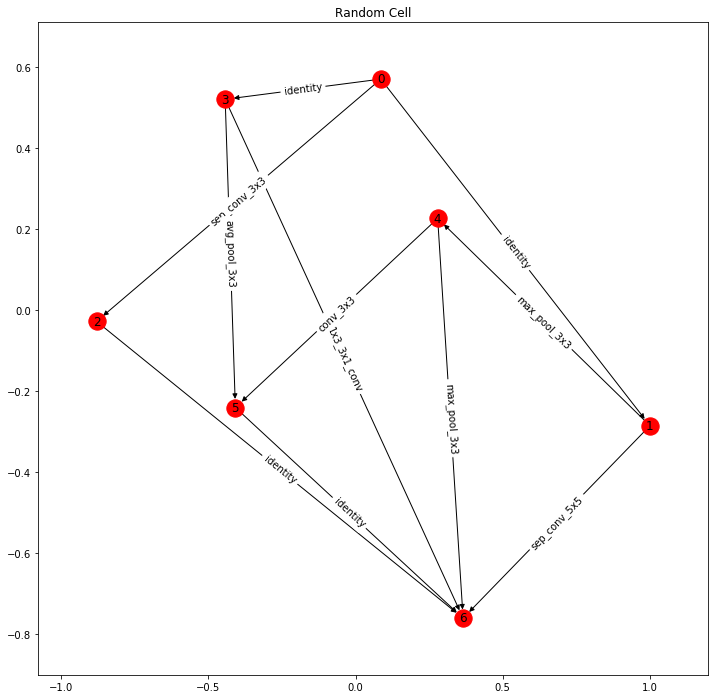

Cell Scaling Factors: [(8.0, 0.5), (2.0, 0.5), (2.0, 0.5), (2.0, 0.5), (2.0, 0.5)]
================================================== CELL 0 ==================================================
==== Node 0 ====
[64, 3, 32, 32]    -> identity (by 1, 24->24)        -> [64, 24, 32, 32]   to Node 1 (96 params)
[64, 3, 32, 32]    -> sep_conv_3x3 (by 1, 24->24)    -> [64, 24, 32, 32]   to Node 2 (1,776 params)
[64, 3, 32, 32]    -> identity (by 1, 24->24)        -> [64, 24, 32, 32]   to Node 3 (96 params)
==== Node 1 ====
[64, 24, 32, 32]   -> max_pool_3x3 (by 1, 24->24)    -> [64, 24, 32, 32]   to Node 4 (0 params)
[64, 24, 32, 32]   -> sep_conv_5x5 (by 2, 24->24)    -> [64, 24, 16, 16]   to Node 6 (2,448 params)
==== Node 2 ====
[64, 24, 32, 32]   -> identity (by 2, 24->24)        -> [64, 24, 16, 16]   to Node 6 (0 params)
==== Node 3 ====
[64, 24, 32, 32]   -> avg_pool_3x3 (by 1, 24->24)    -> [64, 24, 32, 32]   to Node 5 (0 params)
[64, 24, 32, 32]   -> 1x3_3x1_conv (by 2, 24->24)    -> [6

In [19]:
#generate and display random connectivity matrix and DAG
rand_cell = gen_cell(7,sparsity_thresh=.5)
print(rand_cell)
show_matrix(rand_cell,"Random Cell")

#initialize and display model
model = Net(cells=5,matrix=rand_cell,in_dim=data_shape,classes=10)
scales = model.get_cell_upscale()
print("Cell Scaling Factors:",scales)
print(model)

#validate
model_validate(model,verbose=True)